In [3]:
import struct
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

from hw3_utils import BASE_URL, download, GANDataset



In [1]:
from google.colab import files

In [2]:
files.upload()

Saving hw3_utils.py to hw3_utils.py


{'hw3_utils.py': b'import os\nimport gzip\nimport struct\nimport array\nimport numpy as np\nfrom urllib.request import urlretrieve\n\nimport torch\nfrom torch.utils.data import Dataset\n\n\nBASE_URL = \'http://yann.lecun.com/exdb/mnist/\'\n\n\n# Helper functions and imports\ndef download(url, filename):\n    if not os.path.exists(\'./data\'):\n        os.makedirs(\'./data\')\n    out_file = os.path.join(\'./data\', filename)\n    if not os.path.isfile(out_file):\n        urlretrieve(url, out_file)\n\n\ndef mnist():\n    def parse_labels(filename):\n        with gzip.open(filename, \'rb\') as fh:\n            magic, num_data = struct.unpack(">II", fh.read(8))\n            return np.array(array.array("B", fh.read()), dtype=np.uint8)\n\n    def parse_images(filename):\n        with gzip.open(filename, \'rb\') as fh:\n            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))\n            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows

In [ ]:
class DNet(nn.Module):
    """This is discriminator network."""

    def __init__(self):
        super(DNet, self).__init__()
        
        # TODO: implement layers here
        self.conv1 = nn.Conv2d(1,2,3, stride = 1, padding=1)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride =2)
        self.conv2 = nn.Conv2d(2,4,3, stride = 1, padding =1)
        self.conv3 = nn.Conv2d(4,8,3, stride = 1, padding =0)
        self.fullyconnected = nn.Linear(8*25,1)
        
       

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for m in self.children():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
       

    def forward(self, x):
        # TODO: complete forward function
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(-1,8*25)
        x = self.fullyconnected(x)
        
        return x


class GNet(nn.Module):
    """This is generator network."""

    def __init__(self, zdim):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        super(GNet, self).__init__()

        # TODO: implement layers here
        self.linear = nn.Linear(zdim, 1568)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        self.upscale1 = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(32,16,3, stride =1, padding =1)
        self.conv2 = nn.Conv2d(16,8,3, stride =1, padding =1)
        self.conv3 = nn.Conv2d(8,1,3, stride =1, padding =1)
        self.sigmoid = nn.Sigmoid()
        

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for m in self.children():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
        

    def forward(self, z):
        """
        Parameters
        ----------
            z: latent variables used to generate images.
        """
        # TODO: complete forward function
        z = self.linear(z)
        z = self.leakyrelu(z)
        z = z.view(-1,32,7,7)
        z = self.upscale1(z)
        z = self.conv1(z)
        z = self.leakyrelu(z)
        z = self.upscale1(z)
        z =self.conv2(z)
        z = self.leakyrelu(z)
        z= self.conv3(z)
        z = self.sigmoid(z)
        return z
        
    



In [ ]:
class GAN:
    def __init__(self, zdim=64):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        torch.manual_seed(2)
        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._zdim = zdim
        self.disc = DNet().to(self._dev)
        self.gen = GNet(self._zdim).to(self._dev)

   
    #######
    def _get_loss_d(self, batch_size, batch_data, z):
        """This function computes loss for discriminator.

        Parameters
        ----------
            batch_size: #data per batch.
            batch_data: data from dataset.
            z: random latent variable.
        """
          
        total_loss = torch.Tensor([0.0])
        fake_data = self.gen(z)
        real_data = batch_data
        
        #pos_weight = torch.ones([10])
        criterion = torch.nn.BCEWithLogitsLoss()
            
        dis_real = self.disc(real_data).view(-1)
        dis_fake = self.disc(fake_data).view(-1)
            
        loss_real = criterion(dis_real, torch.ones_like(dis_real))
        loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            
        total_loss+=(loss_real+loss_fake)/2
        return total_loss
    ########
    def _get_loss_g(self, batch_size, z):
        """This function computes loss for generator.
        Compute -\sum_z\log{D(G(z))} instead of \sum_z\log{1-D(G(z))}
        
        Parameters
        ----------
            batch_size: #data per batch.
            z: random latent variable.
        """
        
        total_loss = torch.Tensor([0.0])
        fake_data = self.gen(z)
            
        #pos_weight = torch.ones([2])
        criterion = torch.nn.BCEWithLogitsLoss()
            
        dis_fake = self.disc(fake_data).view(-1)
            
        loss_fake = criterion(dis_fake, torch.ones_like(dis_fake))
            
        total_loss+=loss_fake
        return total_loss
       

    def train(self, iter_d=1, iter_g=1, n_epochs=5, batch_size=256, lr=0.0002):

        # first download
        f_name = "train-images-idx3-ubyte.gz"
        download(BASE_URL + f_name, f_name)

        print("Processing dataset ...")
        train_data = GANDataset(
            f"./data/{f_name}",
            self._dev,
            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),
        )
        print(f"... done. Total {len(train_data)} data entries.")

        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=True,
        )

        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)
        dopt.zero_grad()
        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)
        gopt.zero_grad()

        for epoch in tqdm(range(n_epochs)):
            for batch_idx, data in tqdm(
                enumerate(train_loader), total=len(train_loader)
            ):

                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1

                if batch_idx == 0 and epoch == 0:
                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())
                    plt.savefig("goal.pdf")

                if batch_idx == 0 and epoch % 10 == 0:
                    with torch.no_grad():
                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()
                    save_image(
                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True
                    )

                dopt.zero_grad()
                for k in range(iter_d):
                    loss_d = self._get_loss_d(batch_size, data, z)
                    loss_d.backward()
                    dopt.step()
                    dopt.zero_grad()

                gopt.zero_grad()
                for k in range(iter_g):
                    loss_g = self._get_loss_g(batch_size, z)
                    loss_g.backward()
                    gopt.step()
                    gopt.zero_grad()

            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")




Processing dataset ...
... done. Total 60000 data entries.


  1%|          | 1/100 [01:37<2:40:11, 97.09s/it]

E: 0; DLoss: 0.7864583730697632; GLoss: 0.5265127420425415



  2%|▏         | 2/100 [03:20<2:44:56, 100.99s/it]

E: 1; DLoss: 0.7003438472747803; GLoss: 0.6379555463790894



  3%|▎         | 3/100 [04:55<2:38:15, 97.89s/it] 

E: 2; DLoss: 0.7144879102706909; GLoss: 0.6930723786354065



  4%|▍         | 4/100 [06:29<2:34:33, 96.60s/it]

E: 3; DLoss: 0.7089773416519165; GLoss: 0.703102171421051



  5%|▌         | 5/100 [08:05<2:32:43, 96.46s/it]

E: 4; DLoss: 0.6888555288314819; GLoss: 0.7370100021362305



  6%|▌         | 6/100 [09:39<2:29:40, 95.54s/it]

E: 5; DLoss: 0.6996133327484131; GLoss: 0.7042922973632812



  7%|▋         | 7/100 [11:15<2:28:24, 95.75s/it]

E: 6; DLoss: 0.697258472442627; GLoss: 0.7158796787261963



  8%|▊         | 8/100 [12:49<2:25:52, 95.13s/it]

E: 7; DLoss: 0.6898351907730103; GLoss: 0.6692286133766174



  9%|▉         | 9/100 [14:25<2:24:26, 95.24s/it]

E: 8; DLoss: 0.6953543424606323; GLoss: 0.689987301826477



 10%|█         | 10/100 [16:02<2:23:38, 95.77s/it]

E: 9; DLoss: 0.6897268891334534; GLoss: 0.6855041980743408



 11%|█         | 11/100 [17:37<2:21:45, 95.57s/it]

E: 10; DLoss: 0.6858714818954468; GLoss: 0.6903477907180786



 12%|█▏        | 12/100 [19:14<2:20:54, 96.08s/it]

E: 11; DLoss: 0.677715539932251; GLoss: 0.6926742196083069



 13%|█▎        | 13/100 [20:48<2:18:25, 95.47s/it]

E: 12; DLoss: 0.6777551174163818; GLoss: 0.7066980004310608



 14%|█▍        | 14/100 [22:25<2:17:42, 96.07s/it]

E: 13; DLoss: 0.6640135049819946; GLoss: 0.7281731367111206



 15%|█▌        | 15/100 [24:00<2:15:18, 95.51s/it]

E: 14; DLoss: 0.6656293869018555; GLoss: 0.744698166847229



 16%|█▌        | 16/100 [25:35<2:13:42, 95.51s/it]

E: 15; DLoss: 0.6658405065536499; GLoss: 0.7453552484512329



 17%|█▋        | 17/100 [27:14<2:13:21, 96.41s/it]

E: 16; DLoss: 0.6569515466690063; GLoss: 0.6768850088119507



 18%|█▊        | 18/100 [28:51<2:12:07, 96.68s/it]

E: 17; DLoss: 0.6683428287506104; GLoss: 0.7248961329460144



 19%|█▉        | 19/100 [30:32<2:12:24, 98.08s/it]

E: 18; DLoss: 0.6644291281700134; GLoss: 0.7331185340881348



 20%|██        | 20/100 [32:14<2:12:16, 99.21s/it]

E: 19; DLoss: 0.6749632358551025; GLoss: 0.7103202939033508



 21%|██        | 21/100 [33:54<2:11:02, 99.53s/it]

E: 20; DLoss: 0.6772404909133911; GLoss: 0.761410117149353



 22%|██▏       | 22/100 [35:36<2:10:23, 100.30s/it]

E: 21; DLoss: 0.6718356609344482; GLoss: 0.7680910229682922



 23%|██▎       | 23/100 [37:13<2:07:13, 99.13s/it] 

E: 22; DLoss: 0.6822346448898315; GLoss: 0.725544810295105



 24%|██▍       | 24/100 [38:54<2:06:24, 99.79s/it]

E: 23; DLoss: 0.6420304179191589; GLoss: 0.7661612033843994



 25%|██▌       | 25/100 [40:31<2:03:47, 99.03s/it]

E: 24; DLoss: 0.676934003829956; GLoss: 0.7439789175987244



 26%|██▌       | 26/100 [42:08<2:01:12, 98.27s/it]

E: 25; DLoss: 0.681896448135376; GLoss: 0.738003134727478



 27%|██▋       | 27/100 [43:44<1:58:46, 97.62s/it]

E: 26; DLoss: 0.6827186346054077; GLoss: 0.7355042695999146



 28%|██▊       | 28/100 [45:19<1:56:07, 96.76s/it]

E: 27; DLoss: 0.6762062907218933; GLoss: 0.7212151885032654



 29%|██▉       | 29/100 [46:58<1:55:28, 97.59s/it]

E: 28; DLoss: 0.6870638132095337; GLoss: 0.7195699214935303



 30%|███       | 30/100 [48:36<1:53:50, 97.58s/it]

E: 29; DLoss: 0.6883201599121094; GLoss: 0.7255285978317261



 31%|███       | 31/100 [50:15<1:52:34, 97.89s/it]

E: 30; DLoss: 0.6807893514633179; GLoss: 0.7314450144767761



 32%|███▏      | 32/100 [51:52<1:50:49, 97.79s/it]

E: 31; DLoss: 0.6754662394523621; GLoss: 0.7334623336791992



 33%|███▎      | 33/100 [53:28<1:48:41, 97.34s/it]

E: 32; DLoss: 0.6839426755905151; GLoss: 0.7151008248329163



 34%|███▍      | 34/100 [55:08<1:47:53, 98.09s/it]

E: 33; DLoss: 0.6768497824668884; GLoss: 0.7335314750671387



 35%|███▌      | 35/100 [56:46<1:46:10, 98.01s/it]

E: 34; DLoss: 0.6899356245994568; GLoss: 0.7242217063903809



 36%|███▌      | 36/100 [58:25<1:44:49, 98.27s/it]

E: 35; DLoss: 0.6847689747810364; GLoss: 0.7230287790298462



 37%|███▋      | 37/100 [1:00:03<1:43:05, 98.18s/it]

E: 36; DLoss: 0.6907380819320679; GLoss: 0.7021170854568481



 38%|███▊      | 38/100 [1:01:39<1:40:42, 97.46s/it]

E: 37; DLoss: 0.6869710087776184; GLoss: 0.7275853753089905



 39%|███▉      | 39/100 [1:03:17<1:39:15, 97.64s/it]

E: 38; DLoss: 0.6868417263031006; GLoss: 0.7095387578010559



 40%|████      | 40/100 [1:04:51<1:36:35, 96.59s/it]

E: 39; DLoss: 0.6906823515892029; GLoss: 0.706545352935791



 41%|████      | 41/100 [1:06:32<1:36:13, 97.86s/it]

E: 40; DLoss: 0.6846605539321899; GLoss: 0.7065525650978088



 42%|████▏     | 42/100 [1:08:10<1:34:36, 97.86s/it]

E: 41; DLoss: 0.6814162731170654; GLoss: 0.7090661525726318



 43%|████▎     | 43/100 [1:09:44<1:32:05, 96.94s/it]

E: 42; DLoss: 0.6835883259773254; GLoss: 0.7084878087043762



 44%|████▍     | 44/100 [1:11:22<1:30:45, 97.23s/it]

E: 43; DLoss: 0.6870261430740356; GLoss: 0.7011305093765259



 45%|████▌     | 45/100 [1:12:59<1:28:57, 97.05s/it]

E: 44; DLoss: 0.6807436943054199; GLoss: 0.7102944850921631



 46%|████▌     | 46/100 [1:14:37<1:27:39, 97.41s/it]

E: 45; DLoss: 0.6827656030654907; GLoss: 0.7169155478477478



 47%|████▋     | 47/100 [1:16:12<1:25:29, 96.78s/it]

E: 46; DLoss: 0.6789859533309937; GLoss: 0.7198771238327026



 48%|████▊     | 48/100 [1:17:49<1:23:56, 96.85s/it]

E: 47; DLoss: 0.6874414086341858; GLoss: 0.7074474096298218



 49%|████▉     | 49/100 [1:19:27<1:22:24, 96.95s/it]

E: 48; DLoss: 0.691254198551178; GLoss: 0.7073079347610474



 50%|█████     | 50/100 [1:21:04<1:20:50, 97.00s/it]

E: 49; DLoss: 0.685987114906311; GLoss: 0.7123070359230042



 51%|█████     | 51/100 [1:22:41<1:19:19, 97.12s/it]

E: 50; DLoss: 0.6833653450012207; GLoss: 0.7258448004722595



 52%|█████▏    | 52/100 [1:24:18<1:17:41, 97.11s/it]

E: 51; DLoss: 0.6865147352218628; GLoss: 0.7249793410301208



 53%|█████▎    | 53/100 [1:25:54<1:15:47, 96.75s/it]

E: 52; DLoss: 0.6746243238449097; GLoss: 0.7394381761550903



 54%|█████▍    | 54/100 [1:27:33<1:14:46, 97.52s/it]

E: 53; DLoss: 0.6823981404304504; GLoss: 0.7255676984786987



 55%|█████▌    | 55/100 [1:29:10<1:12:49, 97.09s/it]

E: 54; DLoss: 0.6802046895027161; GLoss: 0.7578264474868774



 56%|█████▌    | 56/100 [1:30:49<1:11:40, 97.74s/it]

E: 55; DLoss: 0.6842371225357056; GLoss: 0.7165995240211487



 57%|█████▋    | 57/100 [1:32:26<1:10:01, 97.71s/it]

E: 56; DLoss: 0.6862503290176392; GLoss: 0.7290334701538086



 58%|█████▊    | 58/100 [1:34:04<1:08:17, 97.55s/it]

E: 57; DLoss: 0.6743403673171997; GLoss: 0.7031540274620056



 59%|█████▉    | 59/100 [1:35:43<1:07:04, 98.16s/it]

E: 58; DLoss: 0.6866896152496338; GLoss: 0.7001593708992004



 60%|██████    | 60/100 [1:37:20<1:05:09, 97.74s/it]

E: 59; DLoss: 0.685833752155304; GLoss: 0.7136090397834778



 61%|██████    | 61/100 [1:39:02<1:04:16, 98.88s/it]

E: 60; DLoss: 0.6920751929283142; GLoss: 0.7057888507843018



 62%|██████▏   | 62/100 [1:40:39<1:02:22, 98.49s/it]

E: 61; DLoss: 0.6934599876403809; GLoss: 0.6991232633590698



 63%|██████▎   | 63/100 [1:42:19<1:00:54, 98.78s/it]

E: 62; DLoss: 0.6931748390197754; GLoss: 0.6957026124000549



 64%|██████▍   | 64/100 [1:44:00<59:49, 99.71s/it]  

E: 63; DLoss: 0.6917521953582764; GLoss: 0.6984236836433411



 65%|██████▌   | 65/100 [1:45:40<58:05, 99.58s/it]

E: 64; DLoss: 0.6932828426361084; GLoss: 0.7154365181922913



 66%|██████▌   | 66/100 [1:47:21<56:41, 100.03s/it]

E: 65; DLoss: 0.6794491410255432; GLoss: 0.7200534343719482



 67%|██████▋   | 67/100 [1:49:01<55:03, 100.11s/it]

E: 66; DLoss: 0.685563325881958; GLoss: 0.7153670787811279



 68%|██████▊   | 68/100 [1:50:41<53:17, 99.92s/it] 

E: 67; DLoss: 0.6861950159072876; GLoss: 0.7202963829040527



 69%|██████▉   | 69/100 [1:52:21<51:42, 100.08s/it]

E: 68; DLoss: 0.6849263310432434; GLoss: 0.697776198387146



 70%|███████   | 70/100 [1:54:01<49:59, 99.98s/it] 

E: 69; DLoss: 0.6971560716629028; GLoss: 0.6978330612182617



 71%|███████   | 71/100 [1:55:41<48:18, 99.94s/it]

E: 70; DLoss: 0.6840236186981201; GLoss: 0.6888846158981323



 72%|███████▏  | 72/100 [1:57:20<46:33, 99.78s/it]

E: 71; DLoss: 0.6916937828063965; GLoss: 0.718001663684845



 73%|███████▎  | 73/100 [1:58:59<44:50, 99.65s/it]

E: 72; DLoss: 0.6890432238578796; GLoss: 0.6980005502700806



 74%|███████▍  | 74/100 [2:00:40<43:19, 99.98s/it]

E: 73; DLoss: 0.6867466568946838; GLoss: 0.7013662457466125



 75%|███████▌  | 75/100 [2:02:20<41:39, 100.00s/it]

E: 74; DLoss: 0.6830348968505859; GLoss: 0.7069616317749023



 76%|███████▌  | 76/100 [2:04:02<40:14, 100.62s/it]

E: 75; DLoss: 0.692779004573822; GLoss: 0.6970405578613281



 77%|███████▋  | 77/100 [2:05:41<38:22, 100.10s/it]

E: 76; DLoss: 0.6814340949058533; GLoss: 0.6871465444564819



 78%|███████▊  | 78/100 [2:07:22<36:49, 100.45s/it]

E: 77; DLoss: 0.6909235715866089; GLoss: 0.6989864706993103



 79%|███████▉  | 79/100 [2:09:03<35:10, 100.50s/it]

E: 78; DLoss: 0.6913255453109741; GLoss: 0.694735586643219



 80%|████████  | 80/100 [2:10:47<33:48, 101.42s/it]

E: 79; DLoss: 0.6884021759033203; GLoss: 0.710024893283844



 81%|████████  | 81/100 [2:12:28<32:06, 101.40s/it]

E: 80; DLoss: 0.6869955062866211; GLoss: 0.7049291729927063



 82%|████████▏ | 82/100 [2:14:08<30:19, 101.10s/it]

E: 81; DLoss: 0.6903027892112732; GLoss: 0.7048065662384033



 83%|████████▎ | 83/100 [2:15:51<28:44, 101.43s/it]

E: 82; DLoss: 0.6832427978515625; GLoss: 0.7269432544708252



 84%|████████▍ | 84/100 [2:17:29<26:50, 100.65s/it]

E: 83; DLoss: 0.6820852756500244; GLoss: 0.7007176280021667



 85%|████████▌ | 85/100 [2:19:11<25:15, 101.03s/it]

E: 84; DLoss: 0.6903592944145203; GLoss: 0.7043654322624207



 86%|████████▌ | 86/100 [2:20:50<23:24, 100.30s/it]

E: 85; DLoss: 0.682336688041687; GLoss: 0.7050484418869019



 87%|████████▋ | 87/100 [2:22:32<21:51, 100.87s/it]

E: 86; DLoss: 0.6919853687286377; GLoss: 0.6878427267074585



 88%|████████▊ | 88/100 [2:24:11<20:04, 100.41s/it]

E: 87; DLoss: 0.6918340921401978; GLoss: 0.6906410455703735



 89%|████████▉ | 89/100 [2:25:52<18:24, 100.37s/it]

E: 88; DLoss: 0.6842859983444214; GLoss: 0.696582019329071



 90%|█████████ | 90/100 [2:27:33<16:46, 100.67s/it]

E: 89; DLoss: 0.684678316116333; GLoss: 0.7149636149406433



 91%|█████████ | 91/100 [2:29:13<15:03, 100.36s/it]

E: 90; DLoss: 0.6884093880653381; GLoss: 0.6978675127029419



 92%|█████████▏| 92/100 [2:30:53<13:21, 100.24s/it]

E: 91; DLoss: 0.6925443410873413; GLoss: 0.7098379135131836



 93%|█████████▎| 93/100 [2:32:33<11:41, 100.24s/it]

E: 92; DLoss: 0.6927192211151123; GLoss: 0.6969472169876099



 94%|█████████▍| 94/100 [2:34:13<10:01, 100.26s/it]

E: 93; DLoss: 0.6902238726615906; GLoss: 0.7009119391441345



 95%|█████████▌| 95/100 [2:35:54<08:21, 100.29s/it]

E: 94; DLoss: 0.690592885017395; GLoss: 0.6985411643981934



 96%|█████████▌| 96/100 [2:37:33<06:39, 99.93s/it] 

E: 95; DLoss: 0.692450761795044; GLoss: 0.7031384110450745



 97%|█████████▋| 97/100 [2:39:14<05:01, 100.37s/it]

E: 96; DLoss: 0.6970403790473938; GLoss: 0.6907060146331787



 98%|█████████▊| 98/100 [2:40:55<03:20, 100.41s/it]

E: 97; DLoss: 0.6933152675628662; GLoss: 0.7098707556724548



 99%|█████████▉| 99/100 [2:42:35<01:40, 100.56s/it]

E: 98; DLoss: 0.6884520053863525; GLoss: 0.7170530557632446



100%|██████████| 100/100 [2:44:14<00:00, 98.55s/it] 


E: 99; DLoss: 0.6919825077056885; GLoss: 0.7111372351646423


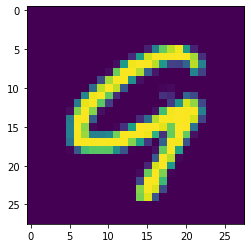

In [ ]:
if __name__ == "__main__":
    gan = GAN()
    gan.train()